In [10]:
import os, sys
import numpy as np
import json
import re
from itertools import combinations
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb
import matplotlib.gridspec as gridspec

import pandas as pd
from Bio import Phylo
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
import umap
import seaborn as sns
from copy import deepcopy

from Bio import SeqIO
from Bio import Entrez
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import motifs 

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.size'] = 6


In [11]:

def xstreme_command_line(promoter_file, bkg_file=None, palindrome_file=None, minw=5, maxw=30, align='center'):
    '''
    Call xstreme using command line. See xstreme help for parameter information
    '''
    call = ''
    if type(palindrome_file) != type(None) and type(bkg_file) != type(None):
        call = 'xstreme --minw ' + str(minw) + ' --maxw ' + str(maxw) + ' --meme-mod anr --align ' + align + ' --p ' + promoter_file + ' --n ' + bkg_file + ' --m ' + palindrome_file + ' --verbosity 0'
    if type(palindrome_file) == type(None) and type(bkg_file) != type(None):
        call = 'xstreme --minw ' + str(minw) + ' --maxw ' + str(maxw) + ' --meme-mod anr --align ' + align + ' --p ' + promoter_file + ' --n ' + bkg_file + ' --verbosity 0'
    if type(palindrome_file) == type(None) and type(bkg_file) == type(None):
        call = 'xstreme --minw ' + str(minw) + ' --maxw ' + str(maxw) + ' --meme-mod anr --align ' + align + ' --p ' + promoter_file + ' --verbosity 0'
    if len(call) == 0:
        raise KeyError(f'Xstreme command line not initialized properly:\nPromoter File {promoter_file}\nBackground File {bkg_file}\nPalindrome File {palindrome_file}')
    os.system(call)
    return

nts = ['A', 'C', 'G', 'T']

def get_best_repeat(motif, minw=5, min_gap=2, allow_direct_repeat=False):
    '''
    Takes bio.motif and returns position (start, end), distance of best inverted repeat
    '''
    ## make matrix from pwm
    try:
        alphabet = motif.pwm.keys()
    except:
        return None, np.inf
    matrix = []
    for key in alphabet: 
        matrix.append(motif.pwm[key])

    matrix = np.array(matrix)

    ## Make reverse complement indices
    com_dict = {'A': 'T',
                'T': 'A',
                'G': 'C',
                'C': 'G',
                'N': 'N'}

    alphabet_dict = {}
    for ai, a in enumerate(list(alphabet)):
        alphabet_dict[a] = ai

    alphabet_index = []
    com_index = []
    for ai, a in enumerate(list(alphabet)):
        alphabet_index.append(alphabet_dict[a])
        com_index.append(alphabet_dict[com_dict[a]])

    ## Find best inverted motif
    min_distance = np.inf
    best_pos = None
    for i in range(0, matrix.shape[1]-2*minw):
        for j in range(i + 2*minw, matrix.shape[1]):
            submatrix = matrix[:, i:j]
            half_len = submatrix.shape[1] // 2
            for gap_size in [min_gap, half_len-minw]:
                motif_len = half_len-gap_size
                half_sub_f = submatrix[:, :motif_len]
                half_sub_r_ir = submatrix[com_index, -motif_len:][:, ::-1]
                half_sub_r_dr = submatrix[:, -motif_len:]
                ir_distance = np.linalg.norm(half_sub_f - half_sub_r_ir)
                dr_distance = np.linalg.norm(half_sub_f - half_sub_r_dr)
                if not allow_direct_repeat: dr_distance = np.inf
                if (ir_distance < min_distance) or (dr_distance < min_distance):
                    best_pos = (i, j)
                    min_distance = min(ir_distance, dr_distance)

    return best_pos, min_distance

def calculate_repeat(all_motifs):
    '''
    Uses get_best_repeat to calculate repeat characteristics for all motifs in a list of motifs
    '''
    best_motif = None
    best_distance = np.inf
    best_pos = None
    for motif in all_motifs:
        _best_pos, min_distance = get_best_repeat(motif)
        if min_distance < best_distance:
            best_motif = motif
            best_distance = min_distance
            best_pos = _best_pos
    return best_motif, best_distance, best_pos

def convert_pssm_to_str(matrix):
    motif_seq = ''
    for ni in range(matrix.shape[1]):
        if matrix[:, ni].sum() == 0:
            nt = 'N'
        else: 
            nt = ['A', 'C', 'G', 'T'][matrix[:, ni].argmax()]
        motif_seq += nt
    return motif_seq




In [12]:
import numpy as np
def process_pssm_fromstr(pssm):
    matrix = np.ones(shape=(4, 30), dtype=float)
    matrix[:] = np.nan
    r_count = 0
    c_count = 0
    float_str = ''
    for ci, char in enumerate(pssm):
        if char == '\n':
            continue
        if char not in ['[', ']', ' ']:
            float_str += char
        else:
            if len(float_str) > 0:
                matrix[r_count, c_count] = float(float_str)
                c_count += 1
                float_str = ''
            if char == ']':
                r_count += 1
                c_count = 0
    return matrix

def process_pssm_fromstr(pssm):
    matrix = np.ones(shape=(4, 30), dtype=float)
    r_count = 0
    c_count = 0
    float_str = ''
    for ci, char in enumerate(pssm):
        if char == '\n':
            continue
        if char not in ['[', ']', ' ']:
            float_str += char
        else:
            if len(float_str) > 0:
                matrix[r_count, c_count] = float(float_str)
                c_count += 1
                float_str = ''
            if char == ']':
                r_count += 1
                c_count = 0
    return matrix

def pssm_similarity(pssm1: np.ndarray, pssm2: np.ndarray) -> float:
    """
    Compare two DNA PSSMs and return their similarity score.
    Similarity is calculated as the average cosine similarity of each column vector.

    Args:
        pssm1 (np.ndarray): First PSSM (4 x N).
        pssm2 (np.ndarray): Second PSSM (4 x N).

    Returns:
        float: Similarity score between 0 and 1.
    """
    # Ensure the matrices have the same shape
    assert pssm1.shape == pssm2.shape, "PSSMs must have the same shape"

    # Adjust for N base
    pssm1 = np.vstack([pssm1, (pssm1.sum(axis=0).max() - pssm1.sum(axis=0)).reshape(1, -1)])
    pssm2 = np.vstack([pssm2, (pssm2.sum(axis=0).max() - pssm2.sum(axis=0)).reshape(1, -1)])

    # Normalize columns
    norm1 = np.linalg.norm(pssm1, axis=0, keepdims=True)
    norm2 = np.linalg.norm(pssm2, axis=0, keepdims=True)
    norm1[norm1 == 0] = 1
    norm2[norm2 == 0] = 1

    # Compute cosine similarity column-wise
    similarities = np.sum(pssm1 * pssm2, axis=0) / (norm1 * norm2)

    # Return the average similarity
    return np.mean(similarities)

def process_distmat(distmat_path, label_by = 'id'):
    with open(distmat_path, 'r') as infile:
        dist = infile.read().splitlines()
        
    ids = []
    matrix = []
    for row in dist[1:]:
        row_clean = ' '.join(row.split())
        id = row_clean.split(' ')[0]
        vals = np.array([float(i) for i in row_clean.split(' ')[1:]])
        ids.append(id)
        matrix.append(vals)

    matrix = np.array(matrix)
    if label_by == 'species':
        labels = [' '.join(i.split('_')[1:]) for i in ids]
    elif label_by == 'genus':
        labels = [i.split('_')[1] for i in ids]
    elif label_by == 'id':
        labels = ids
    else:
        labels = list(range(len(ids)))
    names = [i.split('_')[0] for i in ids]
    
    return matrix, labels, names

def reorder_distance_matrix(dist_matrix, labels, reference_labels):
    """
    Reorder a distance matrix so that its labels match the order of reference_labels.
    
    Parameters:
        dist_matrix (np.ndarray): The distance matrix to reorder (N x N).
        labels (list of str): The labels corresponding to rows/columns of dist_matrix.
        reference_labels (list of str): The desired label order.
        
    Returns:
        np.ndarray: The reordered distance matrix.
    """
    # Create a mapping from label to index
    label_to_index = {label: idx for idx, label in enumerate(labels)}
    
    # Get the indices in the order of reference_labels
    indices = [label_to_index[label] for label in reference_labels]
    
    # Reorder both rows and columns
    reordered_matrix = dist_matrix[np.ix_(indices, indices)]
    return reordered_matrix

def cmyk_to_rgb(c, m, y, k):
    """Convert a single CMYK color to RGB (0-1 range)."""
    r = 1 - min(1, c + k)
    g = 1 - min(1, m + k)
    b = 1 - min(1, y + k)
    return (r, g, b)


nts = ['A', 'C', 'G', 'T']


In [13]:
import re
from Bio import motifs
from Bio.Seq import Seq

def parse_glam2_output(text):
    ## Process text
    lines = text.strip().split("\n")
    alignment = []
    
    ## Get first matrix
    start_found = False
    for line in lines:
        if line.__contains__('Score') and start_found: break
        if line.__contains__('Score') and not start_found: start_found = True
        match = re.match(r'\d+\s+\d+\s+([acgtACGT\.]+)\s+\d+\s+[+-]\s+[\d\.]+', line)
        if match and start_found:
            alignment.append(match.group(1))
    
    return alignment

def process_alignment(alignment, trim_gaps = True, gap_threshold = 0.5, return_fmt = 'motif'):
    '''
    Function to process glam2 output alignment into counts matrix with gap filtering
    '''
    ## Make mappable
    nts = ['A', 'C', 'G', 'T']
    seq_map_dict = {}
    for ni, nt in enumerate(nts): 
        seq_map_dict[nt] = ni

    ## Process to matrix
    matrix = np.zeros(shape=(4, len(alignment[0])))
    for seq in alignment: 
        for ni, nt in enumerate(seq):
            if nt == '.':
                continue
            matrix[seq_map_dict[nt.upper()], ni] += 1

    ## Trim gaps
    if trim_gaps:
        remove_idx = np.argwhere(matrix.sum(axis=0) < len(alignment) * gap_threshold)
        keep_idx = [i for i in list(range(len(alignment[0])))]
        if len(remove_idx) != 0: 
            keep_idx = [i for i in keep_idx if i not in remove_idx]
            matrix = matrix[:, keep_idx]

    if return_fmt == 'matrix':
        return matrix
    
    if return_fmt == 'motif' and not trim_gaps:
        sequences = [Seq(seq.replace('.', '-')) for seq in alignment]
        motif = motifs.create(sequences)
        return motif
    
    if return_fmt == 'motif' and trim_gaps:
        trimmed_alignment = []
        for seq in alignment:
            trimmed_alignment.append(''.join([i for ii, i in enumerate(seq) if ii in keep_idx]))
        sequences = [Seq(seq.replace('.', '-').upper()) for seq in trimmed_alignment]
        motif = motifs.create(sequences)
        return motif


In [14]:
## Load data
df = pd.read_csv('../HTH_Uniref_data_20250317.tsv', sep='\t')
clean_df = df[~df['Cluster_pssm'].isin(['Top rank non-palindromic', 'No motifs']) & (df['id'] == df['Cluster_id'] )]
df = df[df['id'] == df['Cluster_id']]

## Load data
total_df_1 = pd.read_csv('../HTH_Uniref90_protdata.tsv', sep='\t')
total_df_2 = pd.read_csv('../HTH_Uniref70_data_20250317.tsv', sep='\t')
total_df_2['pfam_domain_names'] = total_df_2.id.map(total_df_1.set_index('id')['pfam_domain_names'].to_dict())
total_df_2 = total_df_2[~total_df_2['pfam_domain_names'].isna()]

## Add cluster counts
cluster_count_dict = total_df_2[['Cluster_id', 'id']].groupby('Cluster_id')['id'].agg('count').to_dict()

In [15]:
## Process hmmer output
hmmer_outpath = '/scratch/mgh6/HTH/tmp/TetR_hmm.txt'
hmmerdat = pd.read_csv(hmmer_outpath, sep='\t')
hmmerdat.columns = ['Target', 'HmmName','E-value','BitScore','HMM_Start','HMM_End','TargetStart','TargetEnd','HMM_Seq','Ali_Seq','Description']
aln_seqs = {}
alns = []
fasta_str = ''
for row in hmmerdat.iterrows():
    id = row[1].Target
    aln_seq = row[1].Ali_Seq[30-row[1].HMM_Start : 36-row[1].HMM_Start]
    aln_seqs[id] = aln_seq

## Map
clean_df['Helix'] = clean_df.id.map(aln_seqs)
total_df_2['Helix'] = total_df_2.id.map(aln_seqs)

In [16]:
helix_count_df = total_df_2[['id', 'Helix']].groupby('Helix').agg('count').reset_index()
helix_count_df = helix_count_df[(helix_count_df['Helix'].str.len() == 6) & (helix_count_df['Helix'] != '      ')]
helix_count_df = helix_count_df[helix_count_df['Helix'].str.upper() == helix_count_df['Helix']]
helix_count_df.columns = ['Helix', 'Count']
helix_count_dict = helix_count_df.set_index('Helix')['Count'].to_dict()

In [17]:
## Set inputs
min_num_seqs = 10
min_glam_score = 0
pal_distance = 100
helix_list = helix_count_df[helix_count_df['Count'] >= min_num_seqs]['Helix'].unique()

## Set outputs
cluster_count_dict = {}
cluster_prob_dict = {}
cluster_pssm_dict = {}
cluster_glam_score = {}
cluster_distance = {}
glam_scores = []
pal_distances = []
counts= []

for cluster in tqdm(helix_list):
    cluster_path = f'glam2_{cluster}'
    ## Get path
    full_cluster_path = os.path.join('../glam2_outputs_helix', cluster_path)
    ## Get glam scores
    glam_file = os.path.join(full_cluster_path, 'glam2.txt')
    if not os.path.exists(glam_file): continue
    dat = open(glam_file, 'r').read()
    glam_score = float([i for i in dat.split('\n') if i.__contains__('Score:')][0].split(' ')[1])
    if glam_score < min_glam_score: continue

    ## Scrape top motif
    top_motif = process_alignment(parse_glam2_output(open(glam_file, 'r').read()))

    ## Get loc of best clean motif
    best_motif, best_distance, best_pos = calculate_repeat([top_motif])
    cluster_name = cluster_path.split('_')[-1]
    if not best_motif: 
        best_motif = top_motif
        best_distance = 100
        best_pos = (0, len(top_motif.pssm['A']))
        continue
    if best_distance > pal_distance: 
        continue

    ## Adjust best positions by -2 and +2
    additional_bases = 4
    center = int((best_pos[1] - best_pos[0]) / 2) + best_pos[0]
    lower_lim = max(best_pos[0]-additional_bases, 0)
    upper_lim = center
    # upper_lim = min(best_pos[1]+additional_bases, len(best_motif.pssm['A']))
    best_pos = (lower_lim, upper_lim)

    ## Clean pssm
    clean_pssm = []
    for key in nts:
        clean_pssm.append(best_motif.pssm[key][best_pos[0]:best_pos[1]])

    clean_pssm = np.array(clean_pssm)
    clean_pssm[np.isneginf(clean_pssm)] = -100

    ## Clean counts
    clean_counts = []
    for key in nts:
        clean_counts.append(best_motif.counts[key][best_pos[0]:best_pos[1]])

    clean_counts = np.array(clean_counts)
    clean_probs = clean_counts / clean_counts.sum(axis=0)

    ## Add to list
    cluster_count_dict[cluster_name] = clean_counts
    cluster_prob_dict[cluster_name] = clean_probs
    cluster_pssm_dict[cluster_name] = clean_pssm
    cluster_glam_score[cluster_name] = glam_score
    cluster_distance[cluster_name] = best_distance

    glam_scores.append(glam_score)
    pal_distances.append(best_distance)
    counts.append(helix_count_dict[cluster])

## Convert to arrays
glam_scores = np.array(glam_scores)
pal_distances = np.array(pal_distances)
counts = np.array(counts)


  0%|          | 0/1232 [00:00<?, ?it/s]

100%|██████████| 1232/1232 [00:17<00:00, 71.16it/s]


In [18]:
## Add manual sets for seeding
helix_nt_dict = {
    # ## structural
    # 'KGSFYH': 'TAGACC'
    ##pos 1
    'AGTLYR': 'CGGAGA',
    'PGTLYR': 'CGGAGA',
    'IGTLYR': 'CGGAGG',
    'MGTLYR': 'CGGAGC',
    'SGTLYR': 'TGGAGA',
    'TGTLYR': 'TGGAGA',
    'RGTLYR': 'TGGACA',
    'QGTLYR': 'CGGACA',
    'KGTLYR': 'CGGACT',
    ## pos2
    'KSTLYR': 'GATACG',
    'KTTLYR': 'GCTACG',
    'KRTLYR': 'TAGACT',
    'KATLYR': 'ACGAAA',
    'KGTLYR': 'CGGACT',
    ## Pos3
    'KGSFYH': 'TAGACC',
    'KGTFYH': 'TAGACC',
    'KGAFYH': 'CCGACC',
    'KGGFYH': 'CCGACC',
    ## Pos5
    'KGAFFH': 'CCGACC',
    'KGAFYH': 'CCGACC',
    # ## Pos6
    # 'KGSFYY': 'TAGACC',
    # 'KGSFYH': 'TAGACC',
    # 'KGSFYW': 'ATGACG',
    # 'KGSFYQ': 'ATGACC',
    # 'KGSFYN': 'ATGACC',
    # 'KGSFYF': 'TAGACC',
}



In [19]:
## Make nt pos dict
nt_pos_dict = {}
for ni, nt in enumerate(nts):
    nt_pos_dict[nt] = ni

aligned_helix_pwms = {}
## Get best pwm representing each helix
for key in list(helix_nt_dict.keys()):
    ## Get pwm
    pwm = cluster_count_dict[key]

    ## Get nt seq
    nt_seq = helix_nt_dict[key]

    ## Make temp matrix
    temp_matrix = np.zeros(shape=(4, len(nt_seq)))
    for ni, nt in enumerate(nt_seq):
        pos = nt_pos_dict[nt]
        temp_matrix[pos, ni] = 1

    ## Get best aligned position
    best_pos = 0
    best_sim = -1
    for i in range(pwm.shape[1] - temp_matrix.shape[1]):
        sim = pssm_similarity(temp_matrix, pwm[:, i:i+temp_matrix.shape[1]])
        if sim > best_sim:
            best_pos = i
    
    ## Get best pwm
    best_pwm = pwm[:, best_pos:best_pos+temp_matrix.shape[1]]
    aligned_helix_pwms[key] = best_pwm


In [20]:
## Subset good proteins
clean_helix_lim_df = total_df_2[total_df_2['Helix'].isin(list(aligned_helix_pwms.keys()))].drop_duplicates('Helix', keep='last')


In [ ]:
fixed_starts = '\n'.join([i + '\t0\t0' for i in list(clean_helix_lim_df.id.values)])
open('/scratch/mgh6/HTH/rCLAMPS/precomputedInputs/fixedStarts_TetR.txt', 'w').write(fixed_starts)

241

In [274]:
## Output fasta
fasta_str = ''
for row in clean_helix_lim_df.iterrows():
    id = row[1].id
    aa = row[1].aa
    fasta_str += f'>{id}\n{aa}\n'

open('/scratch/mgh6/HTH/rCLAMPS/precomputedInputs/proteins_TetR.fa', 'w').write(fasta_str)

prob_str = 'prot\tbpos\tbase\tprob\n'
for ri, row in tqdm(enumerate(clean_helix_lim_df.iterrows())):
    id = row[1].id
    cluster_prob = cluster_prob_dict[row[1].Helix]
    for tbpos in range(cluster_prob.shape[1]):
        for tbase_idx in range(cluster_prob.shape[0]):
            tbase = nts[tbase_idx]
            tprob = cluster_prob[tbase_idx, tbpos]
            prob_str += f'{id}\t{tbpos}\t{tbase}\t{tprob:.2e}\n'

open('/scratch/mgh6/HTH/rCLAMPS/precomputedInputs/pwmTab_TetR.txt', 'w').write(prob_str)

18it [00:00, 10304.01it/s]


15864

In [21]:
# Set inputs
min_num_seqs = 10
min_glam_score = 0
pal_distance = 10000
helix_list = helix_count_df[helix_count_df['Count'] >= min_num_seqs]['Helix'].unique()
helix_list = [i for i in helix_list if i not in clean_helix_lim_df['Helix'].values]

## Set outputs
cluster_prob_dict = {}
cluster_prob_dict_secondary = {}
cluster_prob_dict_sum = {}

for cluster in tqdm(helix_list):
    cluster_path = f'glam2_{cluster}'
    ## Get path
    full_cluster_path = os.path.join('../glam2_outputs_helix', cluster_path)
    ## Get glam scores
    glam_file = os.path.join(full_cluster_path, 'glam2.txt')
    if not os.path.exists(glam_file): continue
    dat = open(glam_file, 'r').read()
    glam_score = float([i for i in dat.split('\n') if i.__contains__('Score:')][0].split(' ')[1])
    if glam_score < min_glam_score: continue

    ## Scrape top motif
    top_motif = process_alignment(parse_glam2_output(open(glam_file, 'r').read()))

    ## Get loc of best clean motif
    best_motif, best_distance, best_pos = calculate_repeat([top_motif])
    cluster_name = cluster_path.split('_')[-1]
    if not best_motif: 
        continue
    if best_distance > pal_distance: 
        continue

    ## Adjust best positions by -4 and +4
    additional_bases = 4
    center = int((best_pos[1] - best_pos[0]) / 2) + best_pos[0]
    lower_lim = max(best_pos[0]-additional_bases, 0)
    upper_lim = center
    true_best_pos = (lower_lim, upper_lim)

    ## Also construct reverse matrix
    lower_lim = center
    upper_lim = min(best_pos[1]+additional_bases, len(best_motif.pssm['A']))
    best_pos_secondary = (lower_lim, upper_lim)

    ## Rest best_pos
    best_pos = true_best_pos

    ## Clean probs
    clean_counts = []
    for key in nts:
        clean_counts.append(best_motif.counts[key][best_pos[0]:best_pos[1]])

    clean_counts = np.array(clean_counts)
    clean_probs = clean_counts / clean_counts.sum(axis=0)

    ## Clean probs reverse
    clean_counts_secondary = []
    for key in nts:
        clean_counts_secondary.append(best_motif.counts[key][best_pos_secondary[0]:best_pos_secondary[1]])

    clean_counts_secondary = np.array(clean_counts_secondary)
    clean_probs_secondary = clean_counts_secondary / clean_counts_secondary.sum(axis=0)
    clean_probs_secondary = clean_probs_secondary[::-1, ::-1]

    ## Get best alignment of primary and secondary probablitiy matrices
    temp_matrix_1 = None
    temp_matrix_2 = None
    if clean_probs.shape[1] <= clean_probs_secondary.shape[1]:
        temp_matrix_1 = clean_probs
        temp_matrix_2 = clean_probs_secondary
    else: 
        temp_matrix_2 = clean_probs
        temp_matrix_1 = clean_probs_secondary

    smaller_size = temp_matrix_1.shape[1]
    larger_size = temp_matrix_2.shape[1]
    max_sim = -1
    best_matrices = (temp_matrix_1, temp_matrix_2)
    for offset in range(larger_size - smaller_size + 1):
        sim = pssm_similarity(temp_matrix_1, temp_matrix_2[:, offset:offset+smaller_size])
        if sim > max_sim:
            best_matrices = (temp_matrix_1, temp_matrix_2[:, offset:offset+smaller_size])
            max_sim = sim

    ## Add matching matrices
    output_matrix = (best_matrices[0] * 100 + best_matrices[1] * 100) / 200

    ## Add to list
    cluster_prob_dict[cluster_name] = clean_probs
    cluster_prob_dict_secondary[cluster_name] = clean_probs_secondary
    cluster_prob_dict_sum[cluster_name] = output_matrix


## Subset good proteins
helix_lim_df = total_df_2[total_df_2['Helix'].isin(list(cluster_prob_dict.keys()))].drop_duplicates('Helix', keep='last')


100%|██████████| 1214/1214 [00:14<00:00, 81.38it/s]


In [276]:
## Output fasta
fasta_str = ''
for row in helix_lim_df.iterrows():
    ## Add primary
    id = row[1].id
    aa = row[1].aa
    fasta_str += f'>{id}\n{aa}\n'

open('/scratch/mgh6/HTH/rCLAMPS/precomputedInputs/proteins_TetR.fa', 'a').write(fasta_str)

prob_str = ''
for ri, row in tqdm(enumerate(helix_lim_df.iterrows())):
    ## Add primary
    id = row[1].id
    cluster_prob = cluster_prob_dict_sum[row[1].Helix]
    for tbpos in range(cluster_prob.shape[1]):
        for tbase_idx in range(cluster_prob.shape[0]):
            tbase = nts[tbase_idx]
            tprob = cluster_prob[tbase_idx, tbpos]
            prob_str += f'{id}\t{tbpos}\t{tbase}\t{tprob:.2e}\n'

open('/scratch/mgh6/HTH/rCLAMPS/precomputedInputs/pwmTab_TetR.txt', 'a').write(prob_str)

0it [00:00, ?it/s]

1209it [00:00, 2137.65it/s]


1052540

In [277]:
sldjkfd

NameError: name 'sldjkfd' is not defined

## Get final model

In [1]:
import os, sys
import pickle
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
## Find outputs
model_output_path = 'my_results'
model_output_lead = 'tetRProts'
model_outputs = [i for i in os.listdir(model_output_path) if i.__contains__(model_output_lead)]

In [3]:
## Find best model
best_score = -np.inf
best_model = None
scores = []
for model in tqdm(model_outputs): 
    filename = os.path.join(model_output_path, model, 'result.pickle')
    if not os.path.exists(filename): continue
    with open(filename, 'rb') as f:
        res = pickle.load(f)
    score = [x['ll'] for x in res][0]
    if score > best_score:
        best_model = model
        best_score = score
    scores.append(score)

scores = np.array(scores)

100%|██████████| 250/250 [00:01<00:00, 147.61it/s]


<Axes: >

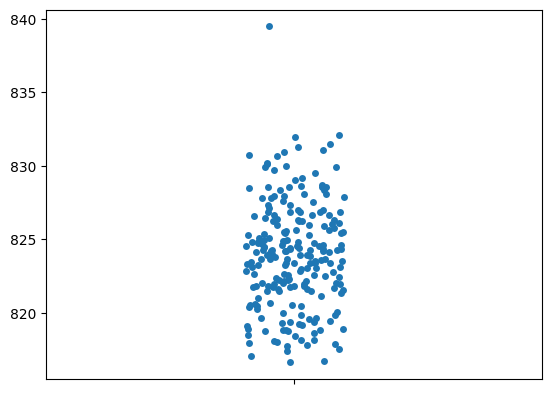

In [4]:
sns.stripplot(- scores / 1000)

In [6]:
## Extract best model
filename = os.path.join(model_output_path, best_model, 'result.pickle')
with open(filename, 'rb') as f:
    res = pickle.load(f)
score = [x['ll'] for x in res][0]          # Find the index of the chain with the optimal model/mapping
start = [x['start'] for x in res][0]  # Extract the PWM starting positions for the optimal mapping
rev = [x['rev'] for x in res][0]      # Extract the PWM orientations for the optimal mapping

In [7]:
print(best_model)
print(score)

tetRProts246
-816619.3281959757


In [ ]:
# ## Pos6
# 'KGSFYY': 'TAGACC',
# 'KGSFYH': 'TAGACC',
# 'KGSFYW': 'ATGACG',
# 'KGSFYQ': 'ATGACC',
# 'KGSFYN': 'ATGACC',
# 'KGSFYF': 'TAGACC',

In [60]:
total_df_2[total_df_2.id == 'N9W0F5'].Helix.values

array(['KGAFFH'], dtype=object)

In [58]:
total_df_2[total_df_2['Helix'] == 'KGSFYN'].id.values[-1]

'T0HBN8'

In [ ]:
start[helix_lim_df[helix_lim_df['Helix'] == 'KGSFYY'].id.values[0]]

np.float64(3.0)

In [48]:
nts

['A', 'C', 'G', 'T']

In [49]:
cluster_prob_dict_sum['KGSFYY'][:, 2:7]

array([[0.03614458, 0.78313253, 0.01807229, 0.94578313, 0.02409639],
       [0.09036145, 0.07228916, 0.        , 0.02409639, 0.89759036],
       [0.0060241 , 0.0060241 , 0.89759036, 0.0060241 , 0.0060241 ],
       [0.86746988, 0.13855422, 0.08433735, 0.02409639, 0.07228916]])

In [ ]:
#  TAGAC
# looking: TAGACC

## Explore coefficients

In [29]:
coeff_path = '/scratch/mgh6/HTH/rCLAMPS/coefficientExplore/TetR/coefTable.txt'
coeff_df = pd.read_csv(coeff_path, sep='\t')

In [30]:
print(coeff_df['aapos'].unique())
print(coeff_df['bpos'].unique())

[31. 30. 34. nan 33. 29.]
[1 2 3 4 5 6]


<Axes: xlabel='aa', ylabel='base'>

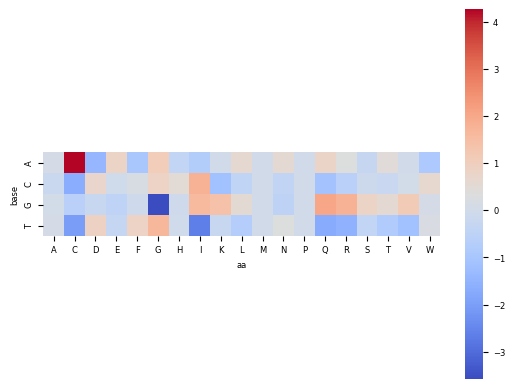

In [41]:
aa_pos = 34
bpos = 1
plt_pivot = pd.pivot(coeff_df[(coeff_df['aapos'] == aa_pos) & (coeff_df['bpos'] == bpos)],
                      index=['aa'], 
                      columns=['base'], 
                      values='coef')
sns.heatmap(plt_pivot.transpose(),
             cmap='coolwarm', square=True)

In [ ]:
clean_helix_lim_df[['id', 'Helix']]

,id,Helix
166930,N9W0F5,KGAFFH
167319,A0A7I7T8V9,TGTLYR
169808,A0A2M7G1E4,KSTLYR
169889,A0A7I7QFV0,AGTLYR
170345,R4KEN9,KGSFYF
172471,A0A7H8JLZ9,SGTLYR
172548,A0A7H8M0A9,PGTLYR
172568,A0A2K8M0E0,RGTLYR
172912,A0A2L0N2Q6,KATLYR
173223,A0A7I7QTZ7,KGSFYW
